# CdA Calculation Walkthrough — 3-Mode Comparison

This notebook breaks down each step of the velodrome CdA analysis so you can:
1. Verify the physics equations
2. Check intermediate calculations
3. Identify what needs correction

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, VBox, HBox, Output, Button, Label
import ipywidgets as widgets
from IPython.display import display, clear_output

# Display settings
pd.set_option('display.precision', 6)
np.set_printoptions(precision=4)
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 4)

---

## 1. Load FIT File

In [2]:
# === Load real FIT file ===

import pandas as pd
from fitparse import FitFile
import io


def parse_fit_file(fit_path_or_file):
    """Parse FIT file and extract cycling data (self-contained version)."""
    if isinstance(fit_path_or_file, str):
        fitfile = FitFile(fit_path_or_file)
    else:
        fitfile = FitFile(io.BytesIO(fit_path_or_file.read()))

    records = []
    for record in fitfile.get_messages("record"):
        record_data = {}
        for data in record:
            record_data[data.name] = data.value
        records.append(record_data)

    df = pd.DataFrame(records)

    required_cols = ["enhanced_speed", "power", "distance"]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    df = df.dropna(subset=required_cols)

    # Convert speed from mm/s to m/s if needed
    if df["enhanced_speed"].max() > 100:
        df["enhanced_speed"] = df["enhanced_speed"] / 1000

    return df


In [3]:
# Load your FIT file
FIT_FILE = "/Users/maringautier/Documents/Quantum Analytics/Cycling/Soudal/Aero_Testing/Martin 1A - Baseline.FIT"  # <-- EDIT THIS PATH IF NEEDED
df = parse_fit_file(FIT_FILE)

print(f"Loaded {len(df)} samples from FIT file")
print(f"Duration: {len(df)/60:.1f} minutes")
print(f"Distance: {df['distance'].max():.0f} m")

Loaded 496 samples from FIT file
Duration: 8.3 minutes
Distance: 6185 m


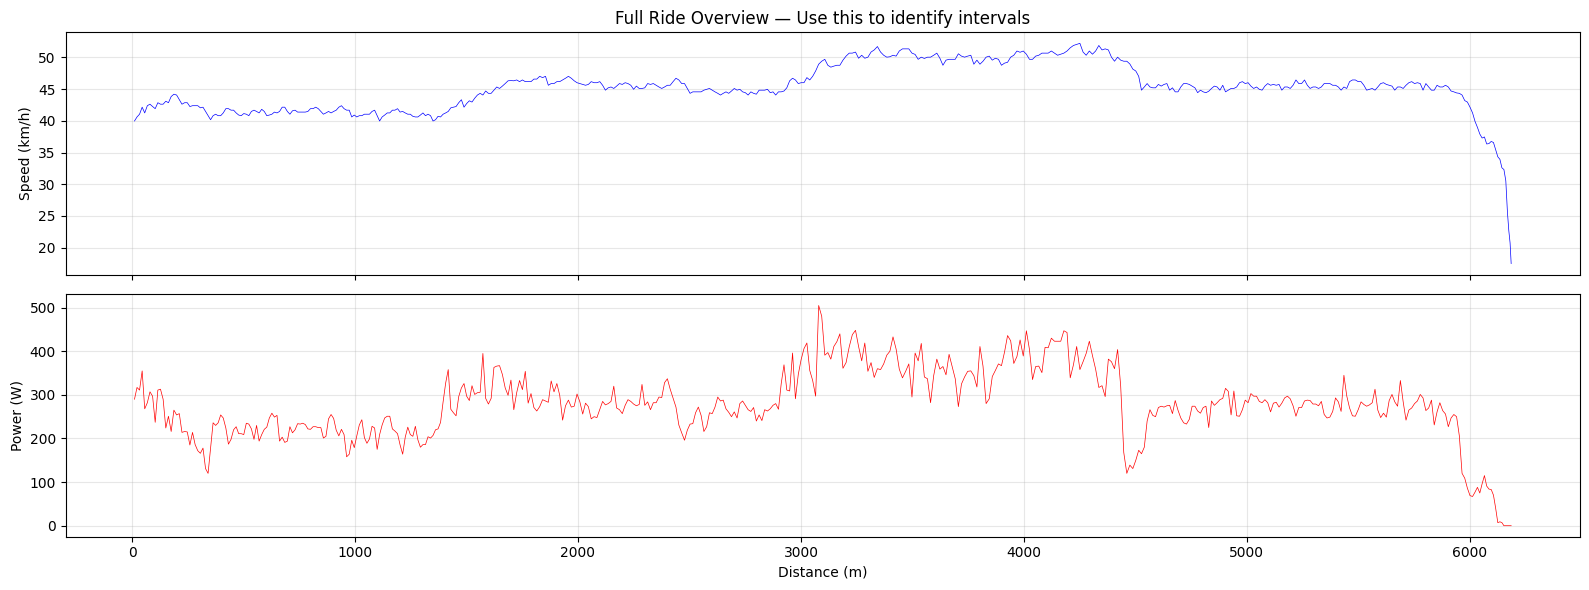

In [6]:
# Quick overview of the data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

ax1.plot(df['distance'], df['enhanced_speed'] * 3.6, 'b-', linewidth=0.5)
ax1.set_ylabel('Speed (km/h)')
ax1.set_title('Full Ride Overview — Use this to identify intervals')
ax1.grid(True, alpha=0.3)

ax2.plot(df['distance'], df['power'], 'r-', linewidth=0.5)
ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('Power (W)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 2. Automatic Interval Detection

Specify the parameters for your intervals:

In [12]:
# ============================================
# INTERVAL DETECTION PARAMETERS — EDIT THESE
# ============================================

# Number of intervals to detect
N_INTERVALS = 4

# Distance of each interval (meters)
INTERVAL_DISTANCE = 1250  # meters

# Target speeds for each interval (km/h)
# Must have exactly N_INTERVALS values
TARGET_SPEEDS_KMH = [45.0, 45.0, 40.0, 50.0]

# Tolerance for distance matching (meters)
DISTANCE_TOLERANCE = 50

# Speed tolerance for matching (km/h)
SPEED_TOLERANCE = 3.0

print(f"Looking for {N_INTERVALS} intervals of {INTERVAL_DISTANCE}m each")
print(f"Target speeds: {TARGET_SPEEDS_KMH} km/h")

Looking for 4 intervals of 1250m each
Target speeds: [45.0, 45.0, 40.0, 50.0] km/h


In [ ]:
# Override interval detection to match app logic and prioritize RMSE

import numpy as np

def detect_intervals(df, n_intervals, interval_distance, target_speeds_kmh,
                     distance_tolerance=50, speed_tolerance=3.0):
    """Detect intervals by prioritizing RMSE (to match app behavior).

    Logic mirrors `utils.interval_detection.detect_4_intervals`:
    - For each target speed, slide a window over distance.
    - Enforce a distance tolerance around the desired interval_distance.
    - Enforce non-overlapping intervals.
    - Among all candidates, pick the one with minimal MSE between speed and target_speed.
    """
    target_speeds_mps = [s / 3.6 for s in target_speeds_kmh]

    distance = df["distance"].values
    speed = df["enhanced_speed"].values

    intervals = []
    used_indices = np.zeros(len(df), dtype=bool)

    for i, target_speed in enumerate(target_speeds_mps):
        best_start, best_end, best_mse = None, None, None

        for start in range(len(df)):
            if used_indices[start]:
                continue

            max_end = start
            while max_end < len(df) and distance[max_end] - distance[start] < interval_distance:
                max_end += 1
            if max_end == len(df):
                break

            actual_dist = distance[max_end] - distance[start]
            if abs(actual_dist - interval_distance) > distance_tolerance:
                continue

            # Skip windows that overlap existing intervals
            if np.any(used_indices[start:max_end]):
                continue

            speed_window = speed[start:max_end]
            mse = np.mean((speed_window - target_speed) ** 2)

            if best_mse is None or mse < best_mse:
                best_mse = mse
                best_start = start
                best_end = max_end

        if best_start is not None:
            avg_speed = speed[best_start:best_end].mean()
            actual_dist = distance[best_end] - distance[best_start]

            intervals.append({
                "interval_num": i + 1,
                "start_idx": best_start,
                "end_idx": best_end,
                "start_distance": distance[best_start],
                "end_distance": distance[best_end],
                "actual_distance": actual_dist,
                "target_speed_kmh": target_speeds_kmh[i],
                "actual_avg_speed_kmh": avg_speed * 3.6,
                "avg_power": df["power"].iloc[best_start:best_end].mean(),
                "rmse_mps": float(np.sqrt(best_mse)),
            })
            used_indices[best_start:best_end] = True
        else:
            print(
                f"WARNING: Could not find interval {i+1} at {target_speeds_kmh[i]} km/h"
            )
            intervals.append(
                {
                    "interval_num": i + 1,
                    "start_idx": None,
                    "end_idx": None,
                    "target_speed_kmh": target_speeds_kmh[i],
                    "rmse_mps": None,
                }
            )

    return intervals




# Run detection
detected_intervals = detect_intervals(
    df, N_INTERVALS, INTERVAL_DISTANCE, TARGET_SPEEDS_KMH,
    DISTANCE_TOLERANCE, SPEED_TOLERANCE
)

print("\nDetected Intervals:")
print("-" * 80)
for intv in detected_intervals:
    if intv['start_idx'] is not None:
        print(f"Interval {intv['interval_num']}: idx [{intv['start_idx']:5d} - {intv['end_idx']:5d}] | "
              f"dist [{intv['start_distance']:6.0f} - {intv['end_distance']:6.0f}] m | "
              f"Δd = {intv['actual_distance']:.0f}m | "
              f"speed = {intv['actual_avg_speed_kmh']:.1f} km/h (target: {intv['target_speed_kmh']:.0f}) | "
              f"power = {intv['avg_power']:.0f} W")
    else:
        print(f"Interval {intv['interval_num']}: NOT FOUND (target: {intv['target_speed_kmh']:.0f} km/h)")


Detected Intervals:
--------------------------------------------------------------------------------
Interval 1: idx [  368 -   468] | dist [  4653 -   5916] m | Δd = 1262m | speed = 45.4 km/h (target: 45) | power = 275 W
Interval 2: idx [  151 -   250] | dist [  1777 -   3027] m | Δd = 1250m | speed = 45.5 km/h (target: 45) | power = 279 W
Interval 3: idx [   21 -   130] | dist [   260 -   1513] m | Δd = 1253m | speed = 41.4 km/h (target: 40) | power = 220 W
Interval 4: idx [  262 -   352] | dist [  3188 -   4448] m | Δd = 1259m | speed = 50.4 km/h (target: 50) | power = 373 W


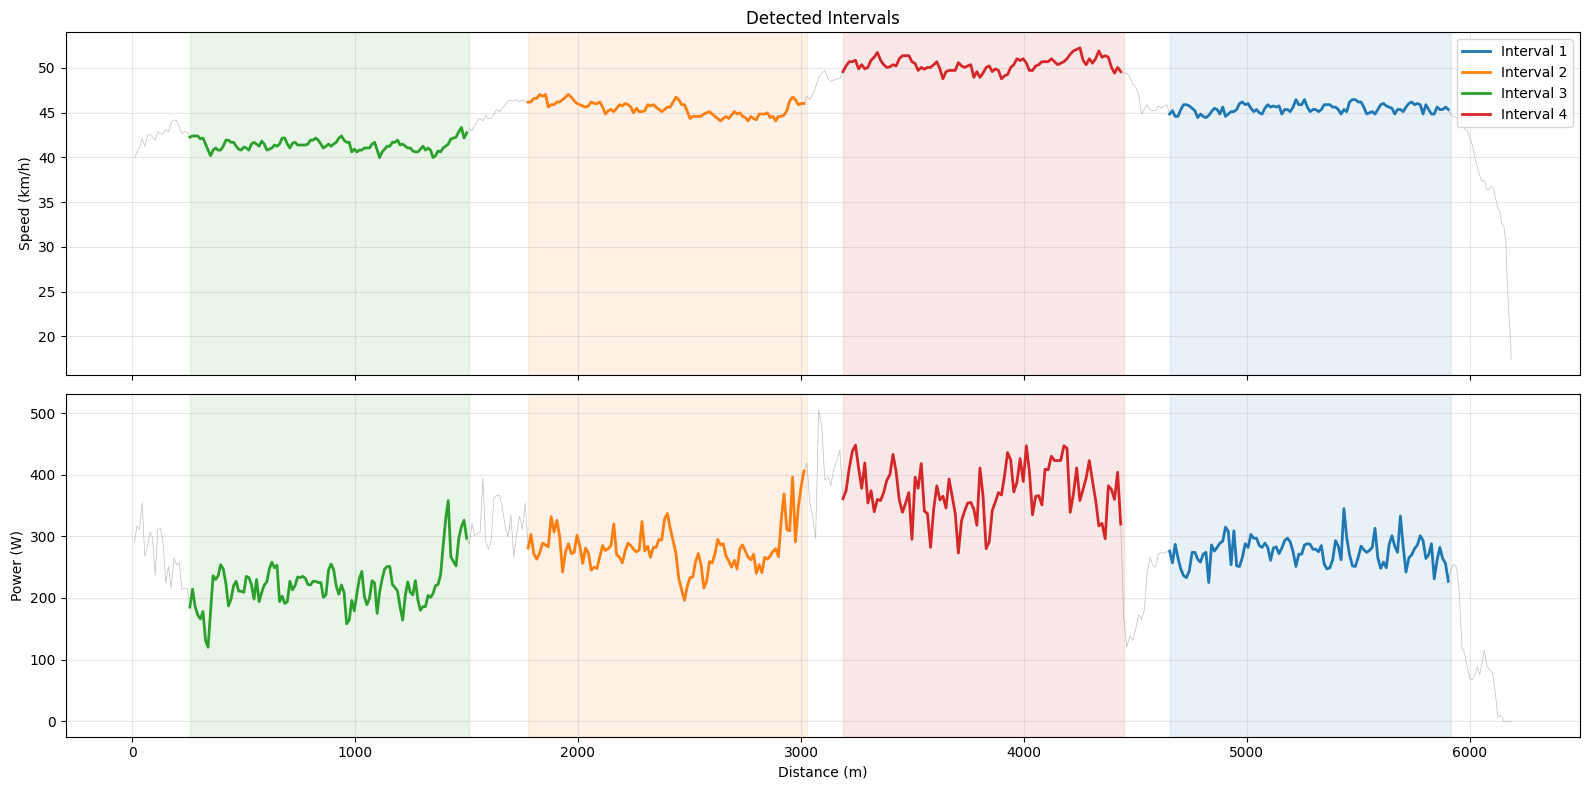

In [24]:
# Visualize detected intervals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

ax1.plot(df['distance'], df['enhanced_speed'] * 3.6, 'gray', linewidth=0.5, alpha=0.5)
ax2.plot(df['distance'], df['power'], 'gray', linewidth=0.5, alpha=0.5)

for i, intv in enumerate(detected_intervals):
    if intv['start_idx'] is not None:
        mask = slice(intv['start_idx'], intv['end_idx'])
        color = colors[i % len(colors)]
        
        ax1.plot(df['distance'].iloc[mask], df['enhanced_speed'].iloc[mask] * 3.6, 
                 color=color, linewidth=2, label=f"Interval {intv['interval_num']}")
        ax1.axvspan(intv['start_distance'], intv['end_distance'], alpha=0.1, color=color)
        
        ax2.plot(df['distance'].iloc[mask], df['power'].iloc[mask],
                 color=color, linewidth=2)
        ax2.axvspan(intv['start_distance'], intv['end_distance'], alpha=0.1, color=color)

ax1.set_ylabel('Speed (km/h)')
ax1.set_title('Detected Intervals')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('Power (W)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 3. Manual Interval Adjustment

Use the sliders below to fine-tune each interval's start and end positions.

**Instructions:**
1. Select an interval from the dropdown
2. Adjust the start/end sliders to fine-tune the boundaries
3. The plot will update in real-time
4. When satisfied, run the next cell to save your adjustments

In [25]:
# Interactive interval modifier for detected intervals
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import VBox, HBox, Dropdown, Button, Label, Output, HTML
from IPython.display import display, clear_output

# Copy detected intervals for adjustment
adjusted_intervals = []
for intv in detected_intervals:
    adjusted_intervals.append({
        'interval_num': intv['interval_num'],
        'start_idx': int(intv['start_idx']) if intv['start_idx'] is not None else 0,
        'end_idx': int(intv['end_idx']) if intv['end_idx'] is not None else 100,
    })

output_plot = Output()
output_stats = Output()

interval_dropdown = Dropdown(
    options=[(f"Interval {adj['interval_num']}", idx) for idx, adj in enumerate(adjusted_intervals)],
    value=0,
    description='Interval:'
)

# Move buttons (by  -10, -1, +1, +10)
move_steps = [-10, -1, 1, 10]
move_labels = [f"← {abs(s)}" if s < 0 else f"{abs(s)} →" for s in move_steps]
move_buttons = [Button(description=lab, layout={'width': '50px'}) for lab in move_labels]

def move_interval(step):
    idx = interval_dropdown.value
    intv = adjusted_intervals[idx]
    interval_len = intv['end_idx'] - intv['start_idx']

    # Move both start and end by step, keeping interval length
    new_start = intv['start_idx'] + step
    new_end = intv['end_idx'] + step

    # Boundaries
    if new_start < 0:
        new_end += -new_start
        new_start = 0
    if new_end > len(df)-1:
        new_start -= new_end - (len(df)-1)
        new_end = len(df)-1
    if new_start < 0:  # again, short interval
        new_start = 0

    # Minimal length: at least 2 points
    if new_end - new_start < 2:
        new_end = new_start + 1
        if new_end > len(df)-1:
            new_end = len(df)-1
            new_start = new_end - 1

    intv['start_idx'] = int(new_start)
    intv['end_idx'] = int(new_end)
    update_all()

def update_plot_and_stats():
    idx = interval_dropdown.value
    intv = adjusted_intervals[idx]
    start, end = intv['start_idx'], intv['end_idx']
    margin = 200

    plot_start = max(0, start - margin)
    plot_end = min(len(df), end + margin)
    
    with output_plot:
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6), sharex=True)
        ax1.plot(df['distance'].iloc[plot_start:plot_end],
                 df['enhanced_speed'].iloc[plot_start:plot_end]*3.6,
                 color='gray', alpha=0.5, label='All', linewidth=0.7)
        ax2.plot(df['distance'].iloc[plot_start:plot_end],
                 df['power'].iloc[plot_start:plot_end],
                 color='gray', alpha=0.5, label='All', linewidth=0.7)
        # Highlight selected interval
        ax1.plot(df['distance'].iloc[start:end],
                 df['enhanced_speed'].iloc[start:end]*3.6,
                 color='blue', linewidth=2, label=f'Interval {intv["interval_num"]}')
        ax2.plot(df['distance'].iloc[start:end],
                 df['power'].iloc[start:end],
                 color='red', linewidth=2)
        ax1.axvline(df['distance'].iloc[start], color='green', linestyle='--', linewidth=1.0)
        ax1.axvline(df['distance'].iloc[end], color='red', linestyle='--', linewidth=1.0)
        ax1.axvspan(df['distance'].iloc[start], df['distance'].iloc[end], alpha=0.12, color='blue')

        ax2.axvline(df['distance'].iloc[start], color='green', linestyle='--', linewidth=1.0)
        ax2.axvline(df['distance'].iloc[end], color='red', linestyle='--', linewidth=1.0)
        ax2.axvspan(df['distance'].iloc[start], df['distance'].iloc[end], alpha=0.12, color='blue')

        ax1.set_ylabel('Speed (km/h)')
        ax1.set_title(f'Interval {intv["interval_num"]} ({start}-{end})')
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)

        ax2.set_xlabel('Distance (m)')
        ax2.set_ylabel('Power (W)')
        ax2.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Stats section: total distance, avg power, avg speed, speed range
    with output_stats:
        clear_output(wait=True)
        if end > start+1:
            v = df['enhanced_speed'].iloc[start:end].values
            p = df['power'].iloc[start:end].values
            d0 = df['distance'].iloc[start]
            d1 = df['distance'].iloc[end]
            total_dist = d1 - d0
            avg_speed = np.mean(v)*3.6
            min_speed = np.min(v)*3.6
            max_speed = np.max(v)*3.6
            avg_power = np.mean(p)
            stat_html = (
                f"<b>Total distance:</b> {total_dist:.1f} m &nbsp;&nbsp; "
                f"<b>Average Power:</b> {avg_power:.1f} W &nbsp;&nbsp; "
                f"<b>Average Speed:</b> {avg_speed:.2f} km/h &nbsp;&nbsp; "
                f"<b>Speed Range:</b> [{min_speed:.2f} - {max_speed:.2f}] km/h"
            )
            display(HTML(stat_html))
        else:
            display(HTML("<b>Interval too short for statistics.</b>"))

def on_dropdown_change(change):
    update_all()

def update_all():
    update_plot_and_stats()

# Connect move buttons to their actions
for s, btn in zip(move_steps, move_buttons):
    btn.on_click(lambda b, s=s: move_interval(s))

interval_dropdown.observe(on_dropdown_change, names='value')

button_row = HBox(move_buttons)
main_box = VBox([interval_dropdown, button_row, output_stats, output_plot])

display(main_box)
update_all()

In [26]:
# === SAVE ADJUSTED INTERVALS ===
# Run this cell after you're satisfied with all interval boundaries

print("FINAL ADJUSTED INTERVALS:")
print("=" * 80)

final_intervals = []
for intv in adjusted_intervals:
    start = intv['start_idx']
    end = intv['end_idx']
    
    if end > start:
        v_mps = df['enhanced_speed'].iloc[start:end].values
        P_watts = df['power'].iloc[start:end].values
        
        final_intervals.append({
            'interval_num': intv['interval_num'],
            'start_idx': start,
            'end_idx': end,
            'v_mps': v_mps,
            'P_watts': P_watts,
            'n_samples': len(v_mps),
            'avg_speed_kmh': np.mean(v_mps) * 3.6,
            'avg_power': np.mean(P_watts),
            'distance': df['distance'].iloc[end] - df['distance'].iloc[start],
        })
        
        print(f"Interval {intv['interval_num']}: [{start:5d} - {end:5d}] | "
              f"{len(v_mps)} samples | "
              f"{final_intervals[-1]['distance']:.0f}m | "
              f"{final_intervals[-1]['avg_speed_kmh']:.1f} km/h | "
              f"{final_intervals[-1]['avg_power']:.0f} W")

print(f"\n✓ {len(final_intervals)} intervals saved for analysis")

FINAL ADJUSTED INTERVALS:
Interval 1: [  368 -   468] | 100 samples | 1262m | 45.4 km/h | 275 W
Interval 2: [  145 -   244] | 99 samples | 1250m | 45.5 km/h | 277 W
Interval 3: [   18 -   127] | 109 samples | 1253m | 41.4 km/h | 217 W
Interval 4: [  262 -   352] | 90 samples | 1259m | 50.4 km/h | 373 W

✓ 4 intervals saved for analysis


---

## 4. Physical Constants & Parameters

**Please verify these values match your test conditions:**

In [27]:
# === PHYSICAL PARAMETERS (EDIT THESE) ===
m_kg = 82.0          # Total mass: rider + bike + equipment (kg)
rho = 1.21           # Air density (kg/m³) — measure on test day!
Crr = 0.004          # Rolling resistance coefficient (typical track tire)
eta = 0.98           # Drivetrain efficiency (power at wheel / power at pedals)
g = 9.80665          # Gravitational acceleration (m/s²)

# Velodrome geometry
R_turn_m = 23.0      # Turn radius (m) — measure from track center line

# Sampling
dt = 1.0             # Sample interval (seconds) — from your FIT file

print(f"Mass: {m_kg} kg")
print(f"Air density: {rho} kg/m³")
print(f"Crr: {Crr}")
print(f"Drivetrain efficiency: {eta}")
print(f"Turn radius: {R_turn_m} m")

Mass: 82.0 kg
Air density: 1.21 kg/m³
Crr: 0.004
Drivetrain efficiency: 0.98
Turn radius: 23.0 m


---

## 5. Select Interval for Analysis

Choose which interval to analyze in detail:

In [136]:
# ============================================
# SELECT WHICH INTERVAL TO ANALYZE
# ============================================
SELECTED_INTERVAL = 4  # Change this (1, 2, 3, ...)

# Get the data
interval_data = final_intervals[SELECTED_INTERVAL - 1]
v_mps = interval_data['v_mps']
P_watts = interval_data['P_watts']
n = len(v_mps)
x = np.arange(n)

print(f"Analyzing Interval {SELECTED_INTERVAL}:")
print(f"  Samples: {n}")
print(f"  Distance: {interval_data['distance']:.0f} m")
print(f"  Avg Speed: {interval_data['avg_speed_kmh']:.2f} km/h")
print(f"  Avg Power: {interval_data['avg_power']:.1f} W")

Analyzing Interval 4:
  Samples: 90
  Distance: 1259 m
  Avg Speed: 50.37 km/h
  Avg Power: 373.1 W


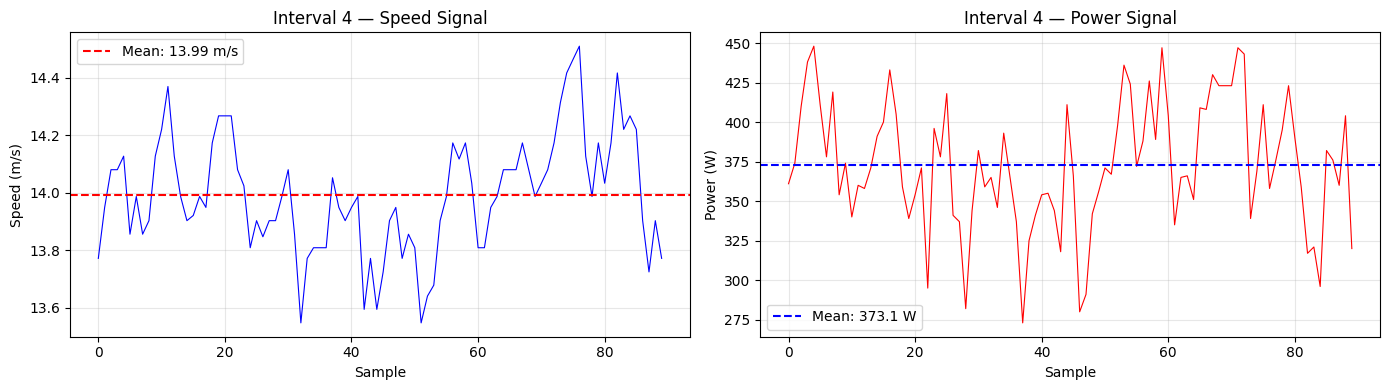

In [137]:
# Quick plot of selected interval
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(v_mps, 'b-', linewidth=0.8)
ax1.set_xlabel('Sample')
ax1.set_ylabel('Speed (m/s)')
ax1.set_title(f'Interval {SELECTED_INTERVAL} — Speed Signal')
ax1.axhline(np.mean(v_mps), color='r', linestyle='--', label=f'Mean: {np.mean(v_mps):.2f} m/s')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(P_watts, 'r-', linewidth=0.8)
ax2.set_xlabel('Sample')
ax2.set_ylabel('Power (W)')
ax2.set_title(f'Interval {SELECTED_INTERVAL} — Power Signal')
ax2.axhline(np.mean(P_watts), color='b', linestyle='--', label=f'Mean: {np.mean(P_watts):.1f} W')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 6. Turn Detection

### 6.1 Physics Background

On a velodrome, riders slow down slightly in the turns (higher resistance) and speed up on straights. This creates a sinusoidal speed pattern with **2 periods per lap** (2 turns per lap).

**Detection method:**
1. Use FFT to find the dominant frequency matching expected lap count
2. Fit a sine wave to the speed signal
3. Classify samples where derivative is negative as "turns" (decelerating phase)

**Is this correct?** The derivative criterion assumes turns = deceleration, which may not perfectly align with physical turn entry/exit.

In [138]:
# Turn detection parameters
# For 1250m interval on 250m track = 5 laps = 10 turns
target_periods = 10  # Expected number of periods (= 2 × number of laps)

# Check for constant speed (edge case)
v_range = np.ptp(v_mps)
print(f"Speed range: {v_range:.4f} m/s")

if v_range < 1e-6:
    print("WARNING: Speed is nearly constant — cannot detect turns")

Speed range: 0.9610 m/s


In [139]:
# Step 1: FFT to find dominant frequency
dx = 1.0  # sample spacing
y = v_mps - np.mean(v_mps)  # remove DC component

freqs = np.fft.rfftfreq(n, d=dx)
spectrum = np.abs(np.fft.rfft(y))

# Convert frequency to periods over total duration
T_total = n * dx
periods_for_freqs = freqs * T_total

# Find frequency closest to target_periods with highest amplitude
idx_candidates = np.argsort(np.abs(periods_for_freqs - target_periods))
close_idxs = [idx for idx in idx_candidates if abs(periods_for_freqs[idx] - target_periods) <= 2]

if close_idxs:
    idx_best = max(close_idxs, key=lambda i: spectrum[i])
else:
    idx_best = idx_candidates[0]

chosen_freq = freqs[idx_best]
chosen_periods = periods_for_freqs[idx_best]

print(f"Chosen frequency: {chosen_freq:.6f} Hz")
print(f"Corresponds to {chosen_periods:.1f} periods over {T_total:.0f} samples")

Chosen frequency: 0.111111 Hz
Corresponds to 10.0 periods over 90 samples


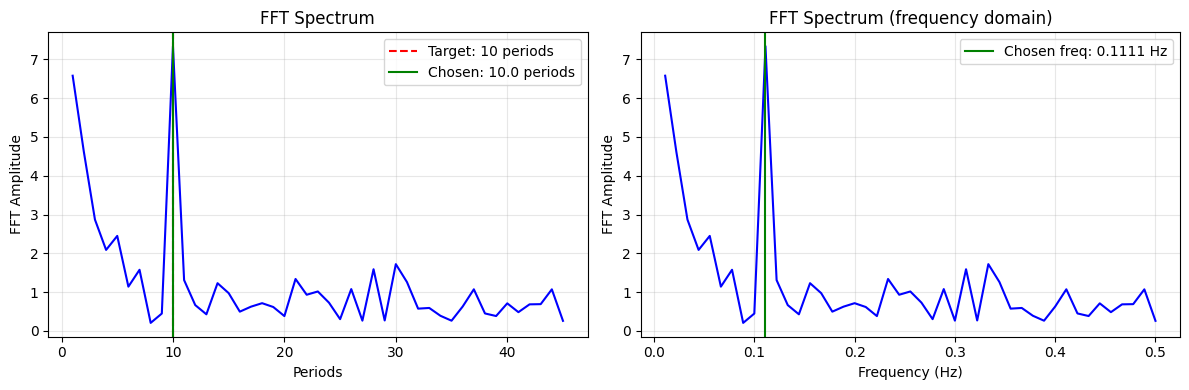

In [140]:
# Plot FFT spectrum
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(periods_for_freqs[1:50], spectrum[1:50], 'b-')
plt.axvline(target_periods, color='r', linestyle='--', label=f'Target: {target_periods} periods')
plt.axvline(chosen_periods, color='g', linestyle='-', label=f'Chosen: {chosen_periods:.1f} periods')
plt.xlabel('Periods')
plt.ylabel('FFT Amplitude')
plt.title('FFT Spectrum')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(freqs[1:50], spectrum[1:50], 'b-')
plt.axvline(chosen_freq, color='g', linestyle='-', label=f'Chosen freq: {chosen_freq:.4f} Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.title('FFT Spectrum (frequency domain)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [141]:
# Step 2: Fit sine wave
def sine_func(x, A, phi, C):
    return A * np.sin(2 * np.pi * chosen_freq * x + phi) + C

A0 = (np.percentile(v_mps, 95) - np.percentile(v_mps, 5)) / 2
p0 = [A0, 0, np.mean(v_mps)]

popt, pcov = curve_fit(sine_func, x, v_mps, p0=p0, maxfev=10000)
A_fit, phi_fit, C_fit = popt

fit_curve = sine_func(x, *popt)

print(f"Fitted parameters:")
print(f"  Amplitude A = {A_fit:.4f} m/s")
print(f"  Phase φ = {phi_fit:.4f} rad = {np.degrees(phi_fit):.1f}°")
print(f"  Offset C = {C_fit:.4f} m/s")

Fitted parameters:
  Amplitude A = 0.1631 m/s
  Phase φ = -0.0342 rad = -2.0°
  Offset C = 13.9925 m/s


In [142]:
# Step 3: Compute R² (goodness of fit)
ss_res = np.sum((v_mps - fit_curve) ** 2)
ss_tot = np.sum((v_mps - np.mean(v_mps)) ** 2)
r_squared = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0

print(f"R² = {r_squared:.4f}")
print(f"")
if r_squared < 0.3:
    print("⚠️ WARNING: R² < 0.3 — poor fit, turn detection unreliable")
elif r_squared < 0.7:
    print("⚠️ CAUTION: R² < 0.7 — moderate fit quality")
else:
    print("✓ Good fit quality")

R² = 0.3244

⚠️ CAUTION: R² < 0.7 — moderate fit quality


In [143]:
# Step 4: Classify turns vs straights
# Turn = where derivative of fit is negative (speed decreasing)
dfit_dx = A_fit * 2 * np.pi * chosen_freq * np.cos(2 * np.pi * chosen_freq * x + phi_fit)
turn_selector = dfit_dx < 0

n_turn = np.sum(turn_selector)
n_straight = np.sum(~turn_selector)

print(f"Turn samples: {n_turn} ({100*n_turn/n:.1f}%)")
print(f"Straight samples: {n_straight} ({100*n_straight/n:.1f}%)")

Turn samples: 40 (44.4%)
Straight samples: 50 (55.6%)


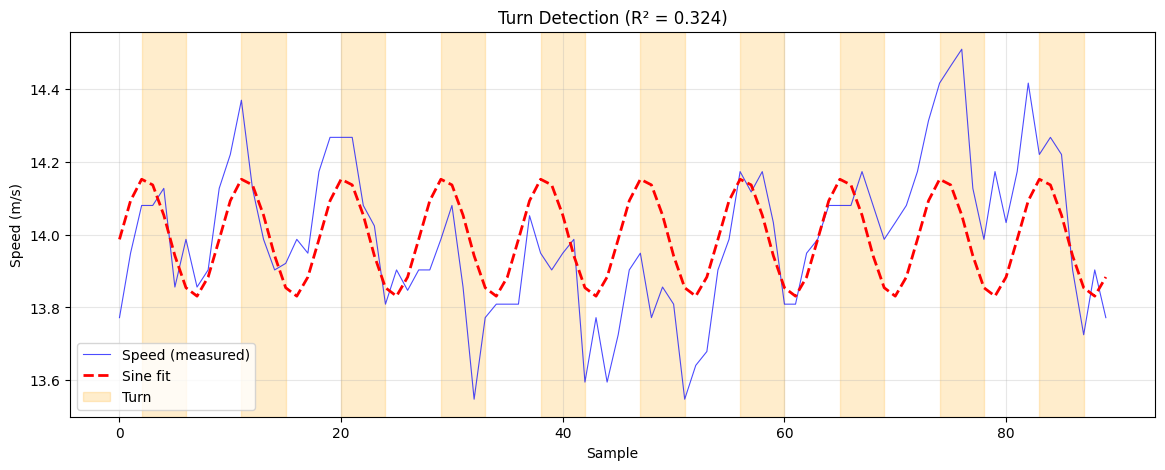

In [144]:
# Visualize turn detection
plt.figure(figsize=(14, 5))

plt.plot(x, v_mps, 'b-', linewidth=0.8, label='Speed (measured)', alpha=0.7)
plt.plot(x, fit_curve, 'r--', linewidth=2, label='Sine fit')

# Shade turn regions
turn_starts = np.where(np.diff(turn_selector.astype(int)) == 1)[0]
turn_ends = np.where(np.diff(turn_selector.astype(int)) == -1)[0]
if turn_selector[0]:
    turn_starts = np.concatenate([[0], turn_starts])
if turn_selector[-1]:
    turn_ends = np.concatenate([turn_ends, [n - 1]])

for i, (s, e) in enumerate(zip(turn_starts, turn_ends)):
    plt.axvspan(s, e, alpha=0.2, color='orange', label='Turn' if i == 0 else '')

plt.xlabel('Sample')
plt.ylabel('Speed (m/s)')
plt.title(f'Turn Detection (R² = {r_squared:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6.2 Lean Angle Calculation

**Physics:** In a banked turn, the rider leans to balance centripetal force:

$$\tan(\phi) = \frac{v^2}{g \cdot R}$$

Where:
- $\phi$ = lean angle from vertical
- $v$ = speed (m/s)
- $g$ = gravitational acceleration (9.81 m/s²)
- $R$ = turn radius (m)

**Question:** Is this the correct formula? Should it account for banking angle of the track?

In [145]:
# Compute lean angle (only in turns)
phi_rad = np.zeros(n)
phi_rad[turn_selector] = np.arctan((v_mps[turn_selector] ** 2) / (g * R_turn_m))

phi_deg = np.degrees(phi_rad)

print(f"Lean angle in turns:")
print(f"  Mean: {np.mean(phi_deg[turn_selector]):.2f}°")
print(f"  Max:  {np.max(phi_deg[turn_selector]):.2f}°")
print(f"  Min:  {np.min(phi_deg[turn_selector]):.2f}°")

Lean angle in turns:
  Mean: 40.93°
  Max:  43.02°
  Min:  39.14°


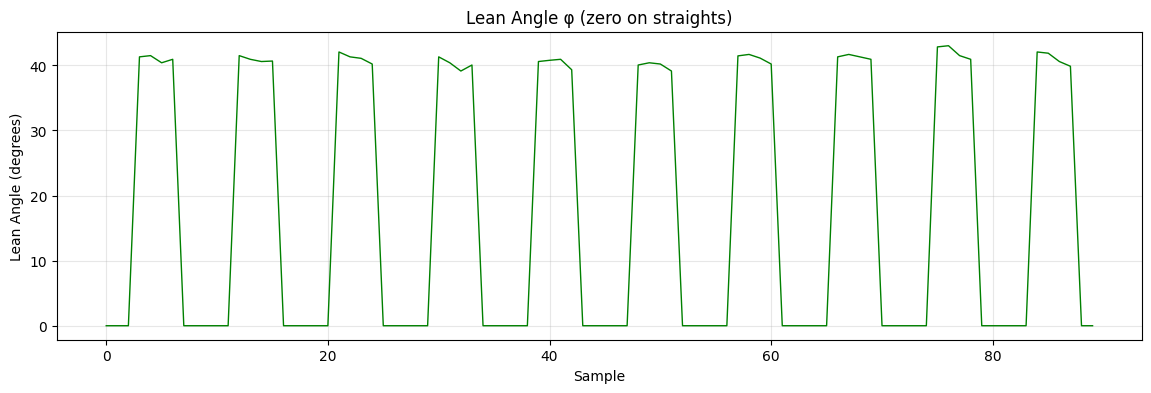

In [146]:
# Plot lean angle
plt.figure(figsize=(14, 4))
plt.plot(x, phi_deg, 'g-', linewidth=1)
plt.xlabel('Sample')
plt.ylabel('Lean Angle (degrees)')
plt.title('Lean Angle φ (zero on straights)')
plt.grid(True, alpha=0.3)
plt.show()

---

## 7. Mode 1: Simple Average CdA

### Physics Model

**Power balance (steady state, no turns):**

$$P_{wheel} = P_{aero} + P_{rolling}$$

Where:
- $P_{wheel} = P_{pedal} \cdot \eta$ (power at wheel after drivetrain losses)
- $P_{aero} = \frac{1}{2} \rho v^3 \cdot CdA$ (aerodynamic drag power)
- $P_{rolling} = m \cdot g \cdot C_{rr} \cdot v$ (rolling resistance power)

**Solving for CdA:**

$$CdA = \frac{P_{wheel} - P_{rolling}}{\frac{1}{2} \rho v^3}$$

**Mode 1 uses mean values:**
- $\bar{v}$ = mean speed
- $\bar{P}$ = mean power

In [147]:
# Mode 1: Simple Average
v_mean = np.mean(v_mps)
P_mean = np.mean(P_watts)

print("=" * 50)
print("MODE 1: SIMPLE AVERAGE")
print("=" * 50)
print(f"\nInput values:")
print(f"  Mean speed: {v_mean:.4f} m/s = {v_mean*3.6:.2f} km/h")
print(f"  Mean power: {P_mean:.2f} W")

MODE 1: SIMPLE AVERAGE

Input values:
  Mean speed: 13.9925 m/s = 50.37 km/h
  Mean power: 373.14 W


In [148]:
# Step-by-step calculation
P_wheel_m1 = P_mean * eta
print(f"\nStep 1: Power at wheel")
print(f"  P_wheel = P_mean × η = {P_mean:.2f} × {eta} = {P_wheel_m1:.2f} W")

# Updated P_rolling calculation to use averaged effective Crr and all instantaneous speeds
P_rolling_m1 = m_kg * g * np.mean(Crr_eff) * np.mean(v_mps)
print(f"\nStep 2: Rolling resistance power (averaged over turns and straights)")
print(f"  P_rolling = m × g × mean(Crr_eff) × mean(v)")
print(f"  P_rolling = {m_kg} × {g} × {np.mean(Crr_eff):.6f} × {np.mean(v_mps):.4f}")
print(f"  P_rolling = {P_rolling_m1:.2f} W")

aero_factor_m1 = 0.5 * rho * v_mean**3
print(f"\nStep 3: Aerodynamic factor")
print(f"  aero_factor = 0.5 × ρ × v³")
print(f"  aero_factor = 0.5 × {rho} × {v_mean:.4f}³")
print(f"  aero_factor = {aero_factor_m1:.2f} W/m²")

CdA_m1 = (P_wheel_m1 - P_rolling_m1) / aero_factor_m1
print(f"\nStep 4: Solve for CdA")
print(f"  CdA = (P_wheel - P_rolling) / aero_factor")
print(f"  CdA = ({P_wheel_m1:.2f} - {P_rolling_m1:.2f}) / {aero_factor_m1:.2f}")
print(f"  CdA = {P_wheel_m1 - P_rolling_m1:.2f} / {aero_factor_m1:.2f}")
print(f"\n  >>> CdA (Mode 1) = {CdA_m1:.4f} m² <<<")


Step 1: Power at wheel
  P_wheel = P_mean × η = 373.14 × 0.98 = 365.68 W

Step 2: Rolling resistance power (averaged over turns and straights)
  P_rolling = m × g × mean(Crr_eff) × mean(v)
  P_rolling = 82.0 × 9.80665 × 0.004448 × 13.9925
  P_rolling = 50.05 W

Step 3: Aerodynamic factor
  aero_factor = 0.5 × ρ × v³
  aero_factor = 0.5 × 1.21 × 13.9925³
  aero_factor = 1657.45 W/m²

Step 4: Solve for CdA
  CdA = (P_wheel - P_rolling) / aero_factor
  CdA = (365.68 - 50.05) / 1657.45
  CdA = 315.63 / 1657.45

  >>> CdA (Mode 1) = 0.1904 m² <<<


---

## 8. Mode 2: Dynamic with Turn Corrections

### Physics Model

**Full power balance (dynamic, with turns):**

$$P_{wheel} = P_{aero} + P_{rolling} + P_{accel}$$

**Turn corrections:**

1. **CdA lean projection:** When leaning, frontal area is reduced:
   $$P_{aero} = \frac{1}{2} \rho v^3 \cdot CdA \cdot \cos(\phi)$$

2. **Rolling resistance lean correction:** Leaning increases normal force on tires:
   $$P_{rolling} = m \cdot g \cdot \frac{C_{rr}}{\cos(\phi)} \cdot v$$

3. **Acceleration power:** Speed changes require kinetic energy:
   $$P_{accel} = m \cdot \frac{dv}{dt} \cdot v$$

**Questions to verify:**
- Is the cos(φ) correction for CdA correct? (reduces frontal area when leaning)
- Is the 1/cos(φ) correction for Crr correct? (increases tire normal force)
- Should there be centripetal force terms?

In [149]:
print("=" * 50)
print("MODE 2: DYNAMIC WITH TURN CORRECTIONS")
print("=" * 50)
print(f"\nUsing all {n} data points with corrections:")
print(f"  - CdA lean projection: cos(φ)")
print(f"  - Crr lean correction: 1/cos(φ)")
print(f"  - Acceleration power: m × dv/dt × v")

MODE 2: DYNAMIC WITH TURN CORRECTIONS

Using all 90 data points with corrections:
  - CdA lean projection: cos(φ)
  - Crr lean correction: 1/cos(φ)
  - Acceleration power: m × dv/dt × v


In [150]:
# Step 1: Compute cos(φ) for all samples
cos_phi = np.cos(phi_rad)

print(f"cos(φ) statistics:")
print(f"  On straights: cos(φ) = 1.0 (no correction)")
print(f"  In turns: cos(φ) = {np.mean(cos_phi[turn_selector]):.4f} (mean)")
print(f"  In turns: cos(φ) = {np.min(cos_phi[turn_selector]):.4f} (min, most lean)")

cos(φ) statistics:
  On straights: cos(φ) = 1.0 (no correction)
  In turns: cos(φ) = 0.7554 (mean)
  In turns: cos(φ) = 0.7311 (min, most lean)



Acceleration dv/dt statistics:
  Mean: -0.0003 m/s²
  Std:  0.0525 m/s²
  Max:  0.1101 m/s²
  Min:  -0.1074 m/s²


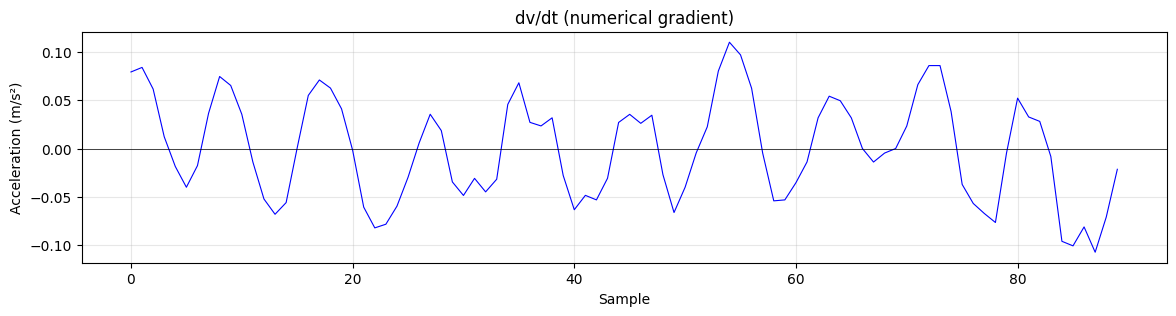

In [151]:
# Step 2: Compute acceleration (dv/dt)
dv_dt = np.gradient(v_mps, dt)
# Smooth acceleration using a moving average with window size 10 for numpy arrays
dv_dt = np.convolve(dv_dt, np.ones(5)/5, mode='same')

print(f"\nAcceleration dv/dt statistics:")
print(f"  Mean: {np.mean(dv_dt):.4f} m/s²")
print(f"  Std:  {np.std(dv_dt):.4f} m/s²")
print(f"  Max:  {np.max(dv_dt):.4f} m/s²")
print(f"  Min:  {np.min(dv_dt):.4f} m/s²")

plt.figure(figsize=(14, 3))
plt.plot(x, dv_dt, 'b-', linewidth=0.8)
plt.axhline(0, color='k', linestyle='-', linewidth=0.5)
plt.xlabel('Sample')
plt.ylabel('Acceleration (m/s²)')
plt.title('dv/dt (numerical gradient)')
plt.grid(True, alpha=0.3)
plt.show()

In [153]:
# Step 3: Compute power components for each sample

# Power at wheel
P_wheel_arr = P_watts * eta

# Rolling resistance with lean correction
Crr_eff = Crr / cos_phi  # increases in turns
P_rolling_arr = m_kg * g * Crr_eff * v_mps

# Acceleration power
P_accel_arr = m_kg * dv_dt * v_mps
P_accel_arr = 0*P_accel_arr


# Aero factor with lean correction
aero_factor_arr = 0.5 * rho * (v_mps**3)

# Residual for CdA fitting
y_residual = P_wheel_arr - P_rolling_arr - P_accel_arr

print("Power components (mean values):")
print(f"  P_wheel:   {np.mean(P_wheel_arr):.2f} W")
print(f"  P_rolling: {np.mean(P_rolling_arr):.2f} W")
print(f"  P_accel:   {np.mean(P_accel_arr):.2f} W")
print(f"  Residual (for aero): {np.mean(y_residual):.2f} W")

Power components (mean values):
  P_wheel:   365.68 W
  P_rolling: 51.49 W
  P_accel:   0.00 W
  Residual (for aero): 314.19 W


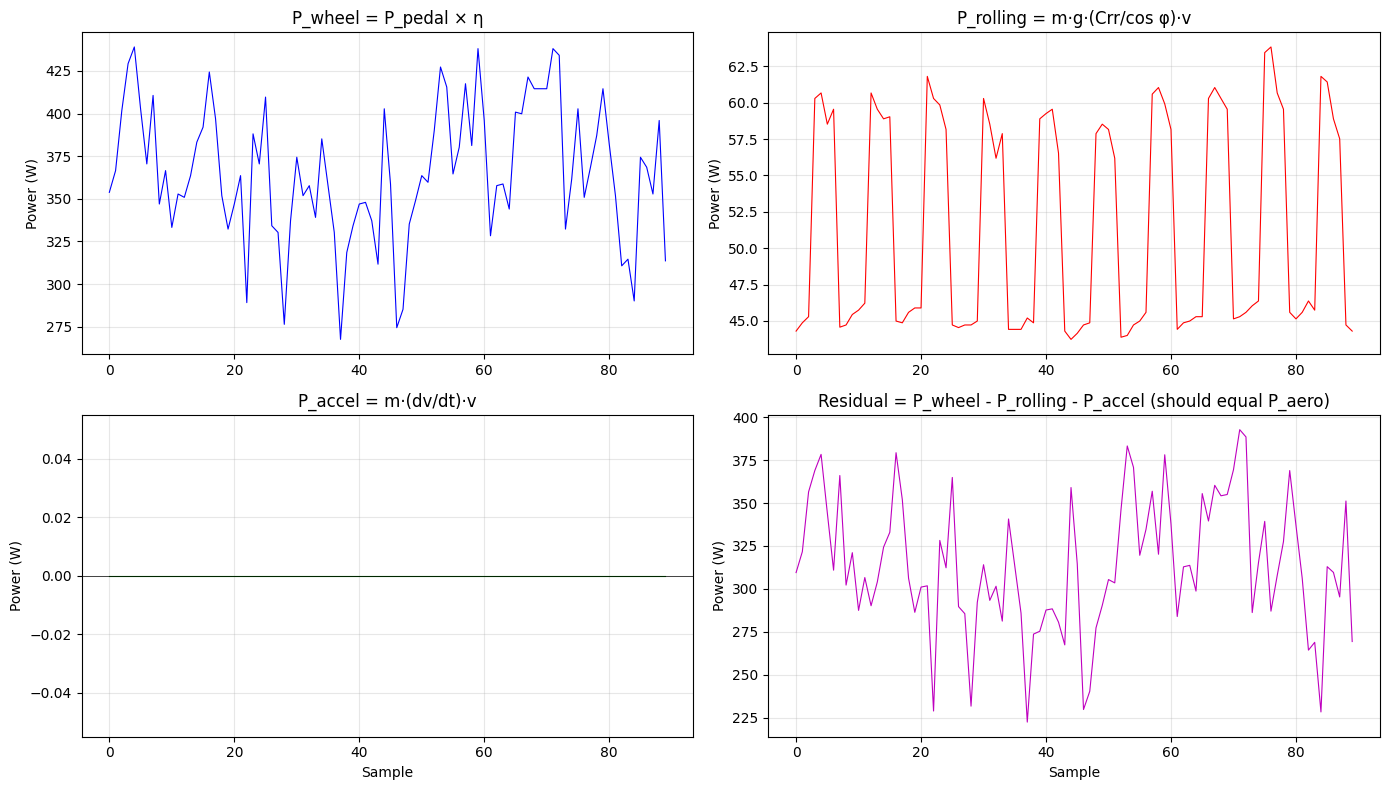

In [154]:
# Visualize power breakdown
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(x, P_wheel_arr, 'b-', linewidth=0.8)
axes[0, 0].set_ylabel('Power (W)')
axes[0, 0].set_title('P_wheel = P_pedal × η')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(x, P_rolling_arr, 'r-', linewidth=0.8)
axes[0, 1].set_ylabel('Power (W)')
axes[0, 1].set_title('P_rolling = m·g·(Crr/cos φ)·v')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(x, P_accel_arr, 'g-', linewidth=0.8)
axes[1, 0].axhline(0, color='k', linestyle='-', linewidth=0.5)
axes[1, 0].set_xlabel('Sample')
axes[1, 0].set_ylabel('Power (W)')
axes[1, 0].set_title('P_accel = m·(dv/dt)·v')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(x, y_residual, 'm-', linewidth=0.8)
axes[1, 1].set_xlabel('Sample')
axes[1, 1].set_ylabel('Power (W)')
axes[1, 1].set_title('Residual = P_wheel - P_rolling - P_accel (should equal P_aero)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [155]:
# Step 4: Solve for CdA using least squares
# Model: y_residual = aero_factor × CdA
# Least squares: CdA = (aero_factor · y_residual) / (aero_factor · aero_factor)

mask = np.isfinite(aero_factor_arr) & (np.abs(aero_factor_arr) > 1e-12) & np.isfinite(y_residual)
af = aero_factor_arr[mask]
yy = y_residual[mask]

CdA_m2 = np.dot(af, yy) / np.dot(af, af)

# Standard error
residuals = yy - af * CdA_m2
sigma2 = np.dot(residuals, residuals) / (len(af) - 1)
se_m2 = np.sqrt(sigma2 / np.dot(af, af))

print(f"\nLeast squares fit:")
print(f"  Valid samples: {np.sum(mask)} / {n}")
print(f"\n  >>> CdA (Mode 2) = {CdA_m2:.4f} ± {se_m2:.4f} m² <<<")


Least squares fit:
  Valid samples: 90 / 90

  >>> CdA (Mode 2) = 0.1891 ± 0.0026 m² <<<


In [156]:
# Verify: compute implied P_aero and check power balance
P_aero_implied = aero_factor_arr * CdA_m2

print(f"\nPower balance check (mean values):")
print(f"  P_wheel:    {np.mean(P_wheel_arr):.2f} W")
print(f"  P_aero:     {np.mean(P_aero_implied):.2f} W")
print(f"  P_rolling:  {np.mean(P_rolling_arr):.2f} W")
print(f"  P_accel:    {np.mean(P_accel_arr):.2f} W")
print(f"  ─────────────────────")
print(f"  Sum (aero+roll+accel): {np.mean(P_aero_implied + P_rolling_arr + P_accel_arr):.2f} W")
print(f"  Difference from P_wheel: {np.mean(P_wheel_arr) - np.mean(P_aero_implied + P_rolling_arr + P_accel_arr):.2f} W")


Power balance check (mean values):
  P_wheel:    365.68 W
  P_aero:     313.59 W
  P_rolling:  51.49 W
  P_accel:    0.00 W
  ─────────────────────
  Sum (aero+roll+accel): 365.08 W
  Difference from P_wheel: 0.60 W


---

## 9. Mode 3: Straights Only

**Rationale:** Use only straight-line data where:
- No lean angle (φ = 0)
- No turn corrections needed
- Cleaner aerodynamic measurement

In [157]:
print("=" * 50)
print("MODE 3: STRAIGHTS ONLY")
print("=" * 50)

# Filter to straights only
v_straight = v_mps[~turn_selector]
P_straight = P_watts[~turn_selector]

print(f"\nUsing {len(v_straight)} straight samples (out of {n} total)")
print(f"Mean speed (straights): {np.mean(v_straight):.4f} m/s = {np.mean(v_straight)*3.6:.2f} km/h")
print(f"Mean power (straights): {np.mean(P_straight):.2f} W")

MODE 3: STRAIGHTS ONLY

Using 50 straight samples (out of 90 total)
Mean speed (straights): 13.9965 m/s = 50.39 km/h
Mean power (straights): 367.24 W


In [159]:
# Standard calculation (no lean corrections)
P_wheel_s = P_straight * eta
P_rolling_s = m_kg * g * Crr * v_straight
aero_factor_s = 0.5 * rho * (v_straight**3)

# No acceleration correction (P_accel_avg removed)
y_s = P_wheel_s - P_rolling_s

# Least squares
mask_s = np.isfinite(aero_factor_s) & (np.abs(aero_factor_s) > 1e-12) & np.isfinite(y_s)
af_s = aero_factor_s[mask_s]
yy_s = y_s[mask_s]

CdA_m3 = np.dot(af_s, yy_s) / np.dot(af_s, af_s)

# Standard error
res_s = yy_s - af_s * CdA_m3
sigma2_s = np.dot(res_s, res_s) / (len(af_s) - 1)
se_m3 = np.sqrt(sigma2_s / np.dot(af_s, af_s))

print(f"\n  >>> CdA (Mode 3) = {CdA_m3:.4f} ± {se_m3:.4f} m² <<<")


  >>> CdA (Mode 3) = 0.1893 ± 0.0040 m² <<<


---

## 10. Results Comparison

In [160]:
print("\n" + "=" * 60)
print(f"RESULTS COMPARISON — INTERVAL {SELECTED_INTERVAL}")
print("=" * 60)

results = pd.DataFrame({
    'Mode': ['1: Simple Average', '2: Dynamic + Turns', '3: Straights Only'],
    'CdA (m²)': [CdA_m1, CdA_m2, CdA_m3],
    'Std Error': [np.nan, se_m2, se_m3],
    'Data Points': [1, n, n_straight],
    'Description': [
        'Single point from mean v, mean P',
        'All points with lean + accel corrections',
        'Straight sections only, no corrections'
    ]
})

print(results.to_string(index=False))


RESULTS COMPARISON — INTERVAL 4
              Mode  CdA (m²)  Std Error  Data Points                              Description
 1: Simple Average  0.190430        NaN            1         Single point from mean v, mean P
2: Dynamic + Turns  0.189081   0.002649           90 All points with lean + accel corrections
 3: Straights Only  0.189252   0.003957           50   Straight sections only, no corrections


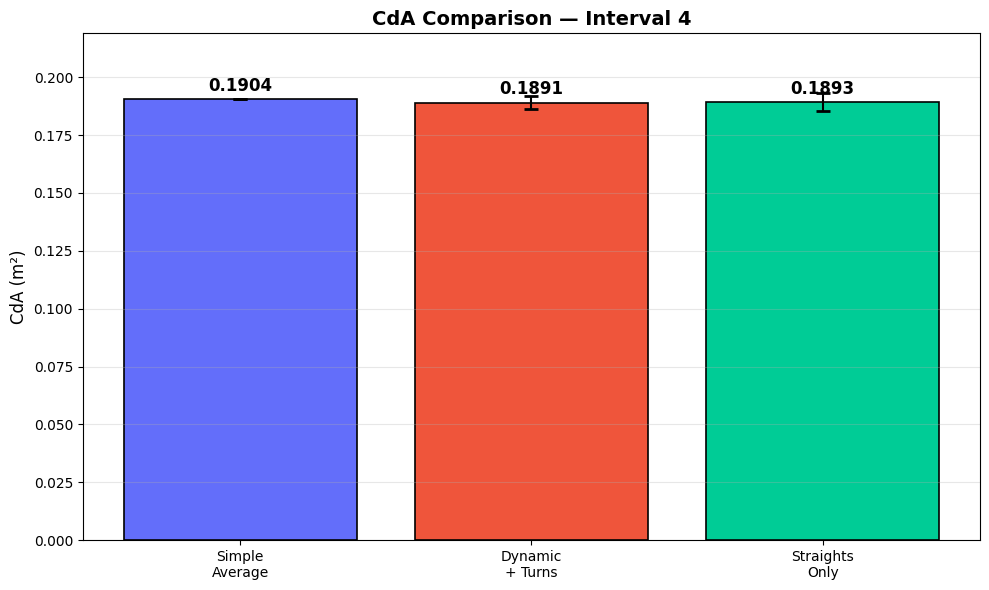

In [162]:
# Bar chart comparison
fig, ax = plt.subplots(figsize=(10, 6))

modes = ['Simple\nAverage', 'Dynamic\n+ Turns', 'Straights\nOnly']
cdas = [CdA_m1, CdA_m2, CdA_m3]
errors = [0, se_m2, se_m3]
colors = ['#636EFA', '#EF553B', '#00CC96']

bars = ax.bar(modes, cdas, color=colors, edgecolor='black', linewidth=1.2)
ax.errorbar(modes, cdas, yerr=errors, fmt='none', color='black', capsize=5, capthick=2)

# Add value labels
for bar, cda in zip(bars, cdas):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
            f'{cda:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('CdA (m²)', fontsize=12)
ax.set_title(f'CdA Comparison — Interval {SELECTED_INTERVAL}', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(cdas) * 1.15)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---

## 11. Analyze ALL Intervals

In [ ]:
# Run analysis on all intervals
all_results = []

for intv in final_intervals:
    v = intv['v_mps']
    P = intv['P_watts']
    n_i = len(v)
    x_i = np.arange(n_i)
    
    # Mode 1: Simple Average
    v_mean_i = np.mean(v)
    P_mean_i = np.mean(P)
    P_wheel_i = P_mean_i * eta
    P_roll_i = m_kg * g * Crr * v_mean_i
    af_i = 0.5 * rho * v_mean_i**3
    cda_m1_i = (P_wheel_i - P_roll_i) / af_i if af_i > 1e-12 else np.nan
    
    # Turn detection
    try:
        y_i = v - np.mean(v)
        freqs_i = np.fft.rfftfreq(n_i, d=1.0)
        spectrum_i = np.abs(np.fft.rfft(y_i))
        T_total_i = n_i
        periods_i = freqs_i * T_total_i
        idx_c = np.argsort(np.abs(periods_i - 10))
        close_i = [j for j in idx_c if abs(periods_i[j] - 10) <= 2]
        idx_b = max(close_i, key=lambda j: spectrum_i[j]) if close_i else idx_c[0]
        freq_i = freqs_i[idx_b]
        
        def sf(x, A, ph, C): return A * np.sin(2*np.pi*freq_i*x + ph) + C
        A0_i = (np.percentile(v, 95) - np.percentile(v, 5)) / 2
        popt_i, _ = curve_fit(sf, x_i, v, p0=[A0_i, 0, np.mean(v)], maxfev=10000)
        fit_i = sf(x_i, *popt_i)
        
        ss_res_i = np.sum((v - fit_i)**2)
        ss_tot_i = np.sum((v - np.mean(v))**2)
        r2_i = 1.0 - ss_res_i/ss_tot_i if ss_tot_i > 0 else 0
        
        dfit_i = popt_i[0] * 2*np.pi*freq_i * np.cos(2*np.pi*freq_i*x_i + popt_i[1])
        ts_i = dfit_i < 0
        
        phi_i = np.zeros(n_i)
        phi_i[ts_i] = np.arctan((v[ts_i]**2)/(g*R_turn_m))
    except:
        r2_i = 0
        ts_i = np.zeros(n_i, dtype=bool)
        phi_i = np.zeros(n_i)
    
    # Mode 2: Dynamic
    cos_phi_i = np.cos(phi_i)
    dv_i = np.gradient(v, dt)
    P_wh_i = P * eta
    P_rl_i = m_kg * g * (Crr/cos_phi_i) * v
    P_ac_i = m_kg * dv_i * v
    af_arr_i = 0.5 * rho * (v**3) * cos_phi_i
    y_res_i = P_wh_i - P_rl_i - P_ac_i
    
    msk_i = np.isfinite(af_arr_i) & (np.abs(af_arr_i) > 1e-12) & np.isfinite(y_res_i)
    if np.sum(msk_i) > 1:
        af_m = af_arr_i[msk_i]
        yy_m = y_res_i[msk_i]
        cda_m2_i = np.dot(af_m, yy_m) / np.dot(af_m, af_m)
        res_m2 = yy_m - af_m * cda_m2_i
        se_m2_i = np.sqrt(np.dot(res_m2, res_m2)/(len(af_m)-1) / np.dot(af_m, af_m))
    else:
        cda_m2_i, se_m2_i = np.nan, np.nan
    
    # Mode 3: Straights
    v_s_i = v[~ts_i]
    P_s_i = P[~ts_i]
    if len(v_s_i) > 1:
        P_wh_s = P_s_i * eta
        P_rl_s = m_kg * g * Crr * v_s_i
        af_s_i = 0.5 * rho * (v_s_i**3)
        y_s_i = P_wh_s - P_rl_s
        msk_s = np.isfinite(af_s_i) & (np.abs(af_s_i) > 1e-12) & np.isfinite(y_s_i)
        af_ss = af_s_i[msk_s]
        yy_ss = y_s_i[msk_s]
        cda_m3_i = np.dot(af_ss, yy_ss) / np.dot(af_ss, af_ss)
        res_m3 = yy_ss - af_ss * cda_m3_i
        se_m3_i = np.sqrt(np.dot(res_m3, res_m3)/(len(af_ss)-1) / np.dot(af_ss, af_ss)) if len(af_ss) > 1 else np.nan
    else:
        cda_m3_i, se_m3_i = np.nan, np.nan
    
    all_results.append({
        'Interval': intv['interval_num'],
        'Samples': n_i,
        'Speed (km/h)': intv['avg_speed_kmh'],
        'Power (W)': intv['avg_power'],
        'R²': r2_i,
        'CdA Mode1': cda_m1_i,
        'CdA Mode2': cda_m2_i,
        'SE Mode2': se_m2_i,
        'CdA Mode3': cda_m3_i,
        'SE Mode3': se_m3_i,
    })

results_df = pd.DataFrame(all_results)
print("\nALL INTERVALS SUMMARY:")
print("=" * 100)
print(results_df.to_string(index=False))


ALL INTERVALS SUMMARY:
 Interval  Samples  Speed (km/h)  Power (W)       R²  CdA Mode1  CdA Mode2  SE Mode2  CdA Mode3  SE Mode3
        1      100     45.436788 274.800000 0.478964   0.188022   0.195681  0.009068   0.184598  0.003192
        2       99     45.455491 277.171717 0.148741   0.189684   0.201064  0.007568   0.188726  0.003725
        3      109     41.383288 217.486239 0.191910   0.191684   0.197598  0.007534   0.199979  0.005451
        4       90     50.372920 373.144444 0.324360   0.193475   0.201551  0.010704   0.189252  0.003957


In [ ]:
# Plot all intervals comparison
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(all_results))
width = 0.25

bars1 = ax.bar(x_pos - width, results_df['CdA Mode1'], width, label='Mode 1: Simple Avg', color='#636EFA')
bars2 = ax.bar(x_pos, results_df['CdA Mode2'], width, label='Mode 2: Dynamic+Turns', color='#EF553B',
               yerr=results_df['SE Mode2'], capsize=3)
bars3 = ax.bar(x_pos + width, results_df['CdA Mode3'], width, label='Mode 3: Straights', color='#00CC96',
               yerr=results_df['SE Mode3'], capsize=3)

ax.set_xlabel('Interval')
ax.set_ylabel('CdA (m²)')
ax.set_title('CdA Comparison Across All Intervals')
ax.set_xticks(x_pos)
ax.set_xticklabels([f"Int {r['Interval']}\n{r['Speed (km/h)']:.0f} km/h" for r in all_results])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---

## 12. Questions for Review

Please check the following and let me know what needs correction:

### Turn Detection
1. Is the sine-fit approach correct for identifying turns?
2. Should turns be defined by derivative < 0, or by a different criterion?
3. Is 2 turns per lap the correct assumption?

### Lean Angle
4. Is φ = arctan(v²/(g·R)) correct?
5. Should the track banking angle be included?

### Mode 2 Corrections
6. **CdA lean projection:** Is `P_aero = 0.5·ρ·v³·CdA·cos(φ)` correct?
7. **Crr lean correction:** Is `Crr_eff = Crr/cos(φ)` correct?
8. **Acceleration power:** Is `P_accel = m·(dv/dt)·v` correct?
9. Are there missing terms (e.g., centripetal force, banking effects)?

### General
10. Are the power balance equations correct?
11. Should we include gradient/elevation changes?
12. Any other physics corrections needed?

In [106]:
# Summary of formulas used
print("FORMULAS USED IN THIS ANALYSIS")
print("=" * 60)
print("\n1. Basic power balance:")
print("   P_wheel = P_aero + P_rolling + P_accel")
print("")
print("2. Power at wheel:")
print("   P_wheel = P_pedal × η")
print("")
print("3. Aerodynamic power (with lean):")
print("   P_aero = 0.5 × ρ × v³ × CdA × cos(φ)")
print("")
print("4. Rolling resistance power (with lean):")
print("   P_rolling = m × g × (Crr / cos(φ)) × v")
print("")
print("5. Acceleration power:")
print("   P_accel = m × (dv/dt) × v")
print("")
print("6. Lean angle:")
print("   φ = arctan(v² / (g × R))")
print("")
print("7. CdA solution (least squares):")
print("   CdA = Σ(aero_factor × y) / Σ(aero_factor²)")
print("   where y = P_wheel - P_rolling - P_accel")
print("         aero_factor = 0.5 × ρ × v³ × cos(φ)")

FORMULAS USED IN THIS ANALYSIS

1. Basic power balance:
   P_wheel = P_aero + P_rolling + P_accel

2. Power at wheel:
   P_wheel = P_pedal × η

3. Aerodynamic power (with lean):
   P_aero = 0.5 × ρ × v³ × CdA × cos(φ)

4. Rolling resistance power (with lean):
   P_rolling = m × g × (Crr / cos(φ)) × v

5. Acceleration power:
   P_accel = m × (dv/dt) × v

6. Lean angle:
   φ = arctan(v² / (g × R))

7. CdA solution (least squares):
   CdA = Σ(aero_factor × y) / Σ(aero_factor²)
   where y = P_wheel - P_rolling - P_accel
         aero_factor = 0.5 × ρ × v³ × cos(φ)
